In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.0 MB/s eta 0:00:00


In [4]:
# standard
import pandas as pd
import numpy as np
import random
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

# BERT
#from transformers import AutoTokenizer, TFAutoModel
from transformers import BertTokenizer, TFBertModel


# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
import tqdm
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = '' # replace with your path

In [5]:
def tokenize(reviews, labels, tokenizer, seq_length):
    ''''''
    # tokenize reviews (this will give you: input_ids, token_type_ids, attention_mask)
    reviews_tokenized = [
        tokenizer(
            n,
            return_tensors='tf',
            truncation=True,
            padding='max_length',
            max_length=seq_length) for n in reviews
    ]
    
    reviews_tokenized_tensor = tf.convert_to_tensor([
                            (reviews_tokenized[i]['input_ids'],
                              reviews_tokenized[i]['token_type_ids'],
                              reviews_tokenized[i]['attention_mask'])
                         for i in range(len(reviews_tokenized))
    ])
    
    # remove empty dimension 
    reviews_tokenized_tensor = reviews_tokenized_tensor[:,:,0,:]
    
    # tensor labels
    labels_tensor = np.array(labels)
    
    return reviews_tokenized_tensor, labels_tensor

In [6]:
def get_bert_embeddings(bert_auto_model, reviews_tokenized_tensor, feature_size=768):
    ''''''
    n = len(reviews_tokenized_tensor)
    seq_len = reviews_tokenized_tensor[0][0].shape[0]
    #bert_pool_embeddings = np.zeros((n, seq_len, feature_size)) # for token embeddings
    bert_pool_embeddings = np.zeros((n, feature_size)) # for sentence embeddings
    bs = 128 
    nsteps = n//bs+1
    
    for i in tqdm.trange(n//bs+1):
        slc = slice(i*bs, (i+1)*bs)
        data = reviews_tokenized_tensor[slc]
        input_ids, token_type_ids, attention_mask = data[:,0], data[:,1], data[:,2]
        #embedding = bert_auto_model(input_ids, token_type_ids, attention_mask).last_hidden_state # for token embeddings
        embedding = bert_auto_model(input_ids, token_type_ids, attention_mask).pooler_output # for sentence embeddings
        bert_pool_embeddings[slc] = embedding
        
    return bert_pool_embeddings

In [7]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/w266project/train.csv')
print('Number of reviews:', df.shape[0])
#print('Unique rating values:', np.sort(df_init.rating.unique()))
df.head()

Number of reviews: 38000


,Unnamed: 0,comment_text,toxic
0,0,people all over the country are so angry about...,1
1,1,barry soetoro has acted with stupidity and mal...,1
2,2,yeah hockeytown or is that you sarah palin moo...,1
3,3,with his words trump described acts of felonio...,1
4,4,walker is a one term gov he knows this he is t...,1


In [10]:
train_valid_reviews, test_reviews, train_valid_labels, test_labels =train_test_split(
    df.comment_text,
    df.toxic,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

train_reviews, valid_reviews, train_labels, valid_labels = train_test_split(
    train_valid_reviews,
    train_valid_labels,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

In [11]:
print('Size train reviews:', len(train_reviews))
print('Size dev reviews', len(valid_reviews))
print('Size test reviews', len(test_reviews))

Size train reviews: 24320
Size dev reviews 6080
Size test reviews 7600


In [12]:
#from transformers import BertTokenizer, TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [13]:
import numpy as np
train_reviews_tokenized_tensor, train_labels_tensor = tokenize(
    train_reviews, train_labels, bert_tokenizer, seq_length=300
)

valid_reviews_tokenized_tensor, valid_labels_tensor = tokenize(
    valid_reviews, valid_labels, bert_tokenizer, seq_length=300
)

test_reviews_tokenized_tensor, test_labels_tensor = tokenize(
    test_reviews, test_labels, bert_tokenizer, seq_length=300
)

In [14]:
print("Doing BERT train embeddings")
train_bert_embeddings = get_bert_embeddings(
    bert_model, train_reviews_tokenized_tensor
) #do train_reviews_tokenized_tensor[:2000,:,:] for only 2000 examples

print("Doing BERT val embeddings")
valid_bert_embeddings = get_bert_embeddings(
    bert_model, valid_reviews_tokenized_tensor
) #do valid_reviews_tokenized_tensor[:200,:,:] for only 200 examples

print("Doing BERT test embeddings")
test_bert_embeddings = get_bert_embeddings(
    bert_model, test_reviews_tokenized_tensor
) #do test_reviews_tokenized_tensor[:200,:,:] for only 200 examples

Doing BERT train embeddings


100%|██████████| 191/191 [09:42<00:00,  3.05s/it]


Doing BERT val embeddings


100%|██████████| 48/48 [02:25<00:00,  3.02s/it]


Doing BERT test embeddings


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


In [ ]:
train_bert_embeddings.shape 

(24320, 768)

In [15]:
# freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

In [16]:
# create copy of our objects (a bit inefficient (memory size) but let's abstract away from this)
train_x = train_bert_embeddings
train_y = train_labels_tensor #do train_labels_tensor[:2000,:,:] for only 2000 examples if you subset the data above

valid_x = valid_bert_embeddings
valid_y = valid_labels_tensor #do valid_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

test_x = test_bert_embeddings
test_y = test_labels_tensor #do test_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

In [17]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
    # clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

    # sse Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer (this will be the sentence embeddings)
    model.add(tf.keras.Input(shape=(num_features, ),
         name='Input'
    ))
    
    
    
    # add output layer for binary classification task
    model.add(Dense(1, use_bias=False, activation='sigmoid'))
    
    # print model summary
    model.summary()
    
    return model
    

# Build the model
logit_model = build_model(num_features=train_x.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 768       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


In [18]:
# compile logit model
logit_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [19]:
# train logit model
tf.random.set_seed(1234)
np.random.seed(1234)
hist= logit_model.fit(x=train_x,
                y=train_y,
                #validation_data=[X_test_std, y_test],
                validation_data=(valid_x, valid_y), 
                batch_size=240,
                epochs=100,
                verbose=0 #silence fit
)

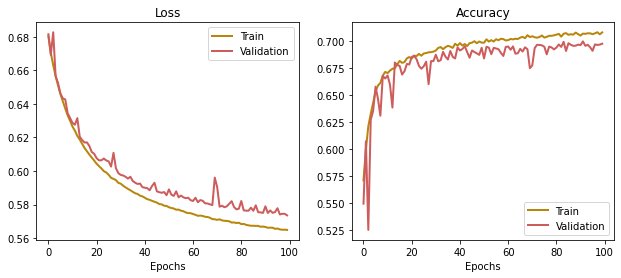

In [20]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [21]:
print('After training this model, evaluation on the validation data shows an accuracy of:',
      np.round(history['val_binary_accuracy'][-1]*100,2), '%'
)

After training this model, evaluation on the validation data shows an accuracy of: 69.77 %


In [22]:
clf = DummyClassifier() # uses Sklearn 

scores = cross_val_score(clf, train_x, train_y)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.501 (+/- 0.00)


In [23]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_p = logit_model.predict(x=test_x).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred = np.where(y_test_pred_p>=0.5, 1, 0)
y_test_pred[:10] # first 10 only

238/238 [==============================] - 0s 1ms/step


array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

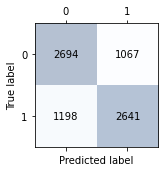

In [24]:
conf_matrix = tf.math.confusion_matrix(
    test_y,
    y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

confusion_matrix_plot(conf_matrix.numpy())

In [25]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      3761
           1       0.71      0.69      0.70      3839

    accuracy                           0.70      7600
   macro avg       0.70      0.70      0.70      7600
weighted avg       0.70      0.70      0.70      7600



ROC AUC: 0.774


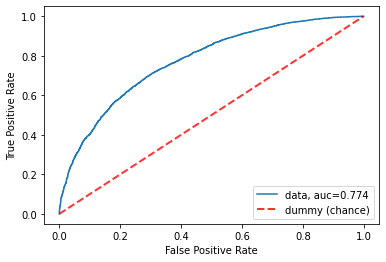

In [26]:
from sklearn import datasets, metrics, model_selection, svm
fpr, tpr, _ = metrics.roc_curve(test_y,  y_test_pred_p)
auc = metrics.roc_auc_score(test_y, y_test_pred_p)
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# add dummy classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='dummy (chance)', alpha=.8)

plt.legend(loc=4)
print('ROC AUC:', np.round(auc,3))